# Searchable Network Architecture

AutoGluon은 딥러닝 모델의 네트워크 구조의 검색 공간을 위한 하이퍼파라메터를 직접 정의할 수 있는 API를 제공합니다. 본 핸즈온에서는 하이퍼파라메터 최적화(HPO)의 일환으로 딥러닝의 아키텍처를 선택하는 예시를 수행합니다. 

NAS(Network Architecture Search)에 대한 심화 주제는 아래 논문과 링크를 참조하세요.
- [Efficient Neural Architecture Search via Parameter Sharing](https://arxiv.org/pdf/1802.03268.pdf) H Pham, MY Guan, B Zoph, QV Le, J Dean International Conference on Machine Learning (ICML), 2018.
- [ProxylessNAS: Direct Neural Architecture Search on Target Task and Hardware](https://arxiv.org/pdf/1812.00332.pdf) Han Cai, Ligeng Zhu, Song Han International Conference on Learning Representations (ICLR), 2019.
- AutoGluon Tutorial: https://auto.gluon.ai/stable/tutorials/nas/enas_proxylessnas.html

## Search Space Tutorial

### Simple Search space

정수형(`autogluon.core.space.Int`), 실수형(`autogluon.core.space.Real`), 범주형(`autogluon.core.space.Categorical`)의 탐색 공간을 제공합니다.

### Nested Search space
`autogluon.core.space.List(...), autogluon.core.space.Dict(...)`로 여러 탐색 송간을 중첩해서 사용할 수 있습니다. 아래 코드 예시를 참조해 주세요.

```python

f = ag.space.List(
        ag.space.Categorical('alpha', 'beta'),
        ag.space.Int(0, 3)    
    )
d = ag.space.Dict(
        key1=ag.space.Categorical('alpha', 'beta'),
        key2=ag.space.Int(0, 3)
    )
```

### Decorator
AutoGluon은 데코레이터(decorator)로 감싼 사용자 정의 함수나 사용자 정의 클래스를 정의해서 탐색 공간을 설정할 수도 있습니다. 아래 코드 예시를 참조해 주세요.

```python

# Function
@ag.func(
    framework=ag.space.Categorical('mxnet', 'pytorch'),
)
def myfunc(framework):
    return framework
i = myfunc()
print(i.rand)

# Class
@ag.obj(
    name=ag.space.Categorical('auto', 'gluon'),
    static_value=10,
    rank=ag.space.Int(2, 5),
)
class MyObj:
    def __init__(self, name, rank, static_value):
        self.name = name
        self.rank = rank
        self.static_value = static_value
    def __repr__(self):
        repr = 'MyObj -- name: {}, rank: {}, static_value: {}'.format(
                self.name, self.rank, self.static_value)
        return repr
h = MyObj()
print(h.rand)
```


## 1. CIFAR ResNet in GluonCV

GluonCV는 사용자가 각 단계(stage)에서 레이어 개수를 지정할 수있는 CIFARResNet을 제공합니다. 예를 들어, 단계당 1개의 레이어만 있는 CIFAR ResNet을 구성할 수 있습니다.

In [1]:
from gluoncv.model_zoo.cifarresnet import CIFARResNetV1, CIFARBasicBlockV1

layers = [1, 1, 1]
channels = [16, 16, 32, 64]
net = CIFARResNetV1(CIFARBasicBlockV1, layers, channels)

`plot_network()`으로 네트워크 구조를 시각화할 수 있습니다.

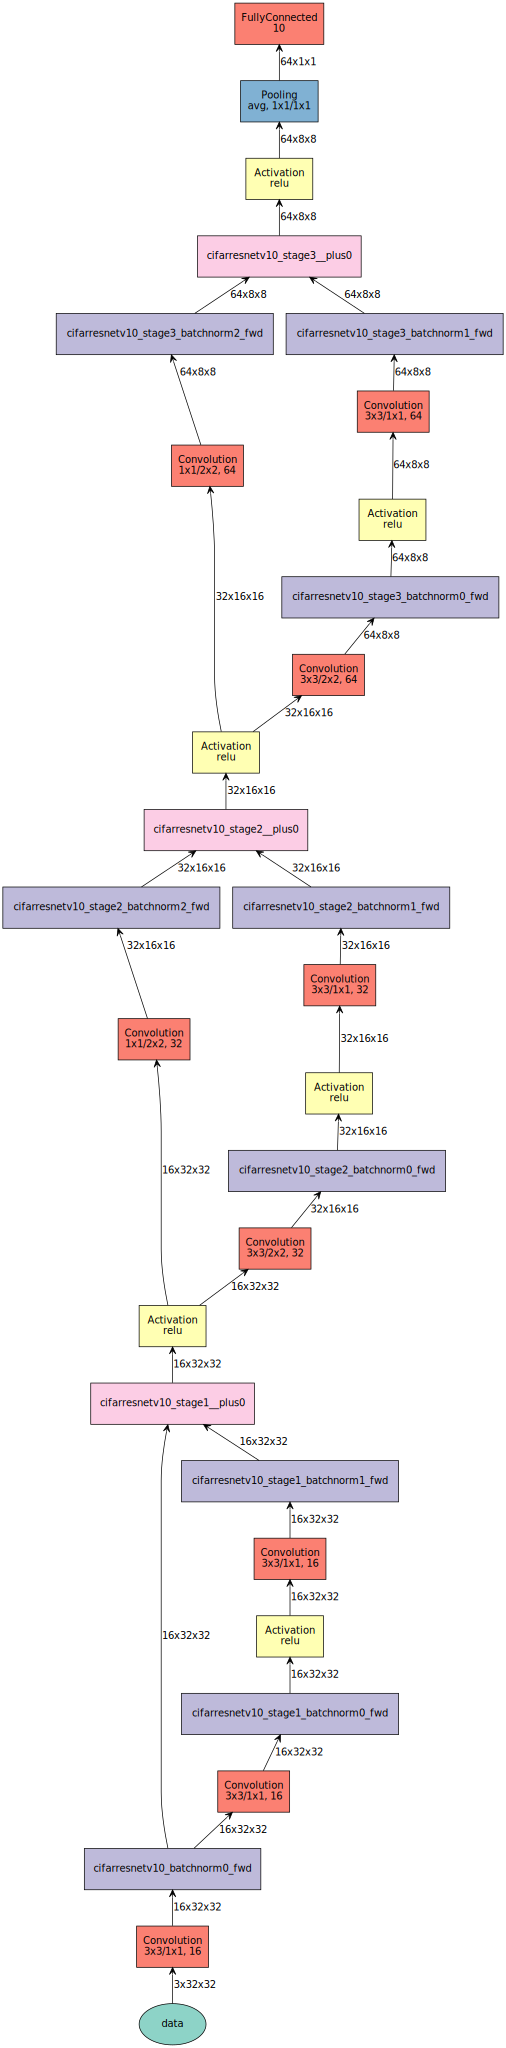

In [2]:
import autogluon.core as ag
from autogluon.vision.utils import plot_network

plot_network(net, (1, 3, 32, 32))

## 2. Searchable Network Architecture Using AutoGluon Object

`autogluon.obj()`는 사용자 정의 클래스에 대해 사용자 정의된 검색 공간을 활성화합니다. 선택할 네트워크가 여러 개인 경우 `autogluon.Categorical()`를 사용할 수도 있습니다.

In [4]:
@ag.obj(
    nstage1=ag.space.Int(2, 4),
    nstage2=ag.space.Int(2, 4),
)
class MyCifarResNet(CIFARResNetV1):
    def __init__(self, nstage1, nstage2):
        nstage3 = 9 - nstage1 - nstage2
        layers = [nstage1, nstage2, nstage3]
        channels = [16, 16, 32, 64]
        super().__init__(CIFARBasicBlockV1, layers=layers, channels=channels)

In [5]:
mynet = MyCifarResNet()
print(mynet.cs)

Configuration space object:
  Hyperparameters:
    nstage1, Type: UniformInteger, Range: [2, 4], Default: 3
    nstage2, Type: UniformInteger, Range: [2, 4], Default: 3



### Decorate Existing Class

기존 클래스에 `autogluon.obj()`로 데코레이팅하는 것도 가능합니다. 예를 들어, Adam Optimizer에 대한 학습률(learning rate) 및 가중치 감소(weight decay)에 대한 파라메터 공간을 검색하려면 아래 코드 예시처럼 데코레이터만 추가하면 됩니다.

In [6]:
from mxnet import optimizer as optim
@ag.obj()
class Adam(optim.Adam):
    pass

In [7]:
myoptim = Adam(learning_rate=ag.Real(1e-2, 1e-1, log=True), wd=ag.Real(1e-5, 1e-3, log=True))
print(myoptim.cs)

Configuration space object:
  Hyperparameters:
    learning_rate, Type: UniformFloat, Range: [0.01, 0.1], Default: 0.0316227766, on log-scale
    wd, Type: UniformFloat, Range: [1e-05, 0.001], Default: 0.0001, on log-scale



### Launch Experiments Using AutoGluon Object

`fit()`의 hyperparameters 인자에 상기에서 정의한 네트워크와 옵티마이저를 사용하여 훈련을 수행합니다.

In [8]:
save_path = 'ag-01-search-space'
!rm -rf $save_path

In [11]:
%%time
from autogluon.vision import ImagePredictor
classifier = ImagePredictor(path=save_path).fit('cifar10',
                  hyperparameters={'net': mynet, 'optimizer': myoptim, 'epochs': 1}, 
                  ngpus_per_trial=1, time_limit=60*2)

INFO:gluoncv.auto.tasks.image_classification:Starting fit without HPO
INFO:ImageClassificationEstimator:modified configs(<old> != <new>): {
INFO:ImageClassificationEstimator:root.train.rec_val_idx ~/.mxnet/datasets/imagenet/rec/val.idx != auto
INFO:ImageClassificationEstimator:root.train.num_workers 4 != 8
INFO:ImageClassificationEstimator:root.train.num_training_samples 1281167 != -1
INFO:ImageClassificationEstimator:root.train.rec_val   ~/.mxnet/datasets/imagenet/rec/val.rec != auto
INFO:ImageClassificationEstimator:root.train.lr        0.1 != 0.01
INFO:ImageClassificationEstimator:root.train.batch_size 128 != 16
INFO:ImageClassificationEstimator:root.train.data_dir  ~/.mxnet/datasets/imagenet != auto
INFO:ImageClassificationEstimator:root.train.rec_train_idx ~/.mxnet/datasets/imagenet/rec/train.idx != auto
INFO:ImageClassificationEstimator:root.train.rec_train ~/.mxnet/datasets/imagenet/rec/train.rec != auto
INFO:ImageClassificationEstimator:root.train.epochs    10 != 1
INFO:ImageCl

CPU times: user 4min 4s, sys: 43.4 s, total: 4min 48s
Wall time: 2min 19s


In [12]:
print(classifier.fit_summary())

{'train_acc': 0.5766666666666667, 'valid_acc': 0, 'total_time': 119.94350838661194, 'best_config': {'model': 'resnet50_v1b', 'lr': 0.01, 'num_trials': 1, 'epochs': 1, 'batch_size': 16, 'nthreads_per_trial': 128, 'ngpus_per_trial': 1, 'time_limits': 120, 'search_strategy': 'random', 'dist_ip_addrs': None, 'log_dir': 'ag-01-search-space/0a6b2a1e', 'custom_net': MyCifarResNet(
  (features): HybridSequential(
    (0): Conv2D(None -> 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=None)
    (2): HybridSequential(
      (0): CIFARBasicBlockV1(
        (body): HybridSequential(
          (0): Conv2D(16 -> 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=None)
          (2): Activation(relu)
          (3): Conv2D(16 -> 16, kernel_size=(3, 3), st